# Stable Voting

Implementation of Simple Stable Voting and Stable Voting from the paper [Stable Voting](https://arxiv.org/abs/2108.00542) by W. Holliday and E. Pacuit.  

In [31]:
# import the Profile class
from voting.profiles import *

# import the voting methods
from voting.voting_methods import *

from voting.generate_profiles import *
import math
import pandas as pd
from itertools import product, combinations

from functools import partial
from multiprocess import Pool, cpu_count
import pickle
import timeit

import copy
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()


In [32]:
def display_mg(mg): 
    
    pos = nx.circular_layout(mg)
    nx.draw(mg, pos, 
            font_size=20, font_color='white', node_size=700, 
            width=1.5, with_labels=True)
    labels = nx.get_edge_attributes(mg,'weight')
    nx.draw_networkx_edge_labels(mg,pos,edge_labels=labels, font_size=14, label_pos=0.3)
    plt.show()


### Simple Stable Voting 

Simple Stable Voting selects a winner as follows:

1. If only one candidate $a$ appears on all ballots, then $a$ wins.
2. Otherwise list all head-to-head matches of the form $a$ vs. $b$ in order from the largest to smallest margin of $a$ vs. $b$. Find the first match $a$ vs. $b$ in the list such that $a$ wins according to Simple Stable Voting *after $b$ is removed from all ballots*; this $a$ is the winner for the original set of ballots.  

Note that if there are two matches $a$ vs. $b$ and $a'$ vs. $b'$ with the same margins such that $a$ wins after $b$ is removed from the ballots, and $a'$ wins after $b'$ is removed from the ballots, then $a$ and $a'$ are tied Simple Stable Voting winners for the original set of ballots.


In [33]:
# This code is available in voting/voting_methods.py but is included here for reference. 

def simple_stable_voting_(profile, curr_cands = None, mem_sv_winners = {}): 
    '''
    Determine the Simple Stable Voting winners for the profile while keeping track 
    of the winners in any subprofiles checked during computation. 
    '''
    
    # curr_cands is the set of candidates who have not been removed
    curr_cands = curr_cands if not curr_cands is None else profile.candidates
    sv_winners = list()
    
    matches = [(a, b) for a in curr_cands for b in curr_cands if a != b]
    margins = list(set([profile.margin(a, b) for a,b in matches]))
        
    if len(curr_cands) == 1: 
        mem_sv_winners[tuple(curr_cands)] = curr_cands
        return curr_cands, mem_sv_winners
    for m in sorted(margins, reverse=True):
        for a, b in [ab_match for ab_match in matches 
                     if profile.margin(ab_match[0], ab_match[1])  == m]:
            if a not in sv_winners: 
                cands_minus_b = sorted([c for c in curr_cands if c!= b])
                if tuple(cands_minus_b) not in mem_sv_winners.keys(): 
                    ws, mem_sv_winners = simple_stable_voting_(profile, 
                                                               curr_cands = [c for c in curr_cands if c != b],
                                                               mem_sv_winners = mem_sv_winners)
                    mem_sv_winners[tuple(cands_minus_b)] = ws
                else: 
                    ws = mem_sv_winners[tuple(cands_minus_b)]
                if a in ws:
                    sv_winners.append(a)
        if len(sv_winners) > 0: 
            return sorted(sv_winners), mem_sv_winners
        
@vm_name("Simple Stable Voting")
def simple_stable_voting(profile): 
    
    return simple_stable_voting_(profile, curr_cands = None, mem_sv_winners = {})[0]


### Stable Voting

Stable Voting is analogously to Simple Stable Voting:

1. If there is only one undefeated candidate  $a$, then $a$ wins.
2. Otherwise list all head-to-head matches of the form $a$ vs. $b$ in order from the largest to smallest margin of $a$ vs. $b$, where $a$ is undefeated. Find the first match $a$ vs. $b$ in the list such that $a$ wins according to  Stable Voting *after $b$ is removed from all ballots*; this $a$ is the winner for the original set of ballots.  

We say that $b$ *does not defeat* $a$ if we can make a list of candidates starting with $a$ and ending with $b$ such that the margin of each candidate vs. the next candidate in the list is at least the margin of $b$ vs. $a$; if there is no such list, then $b$ defeats $a$; and $a$ is undefeated if there is no $b$ that defeats $a$ (this notion of defeat is defended at length in [Axioms for Defeat in Democratic Elections](https://arxiv.org/abs/2008.08451)). 


In [41]:
def find_undefeated_candidates(profile, curr_cands = None):   
    """
    A path from candidate a to candidate b is a list of candidates starting with a and ending with b 
    such that each candidate in the list has a nonzero margin vs. the next candidate in the list. 
    The strength of a path is the minimum margin between consecutive candidates in the path 
    The strength of the pair of candidates (a,b) is strength of the strongest path from a to b.   
    We find these strengths using the Floyd-Warshall Algorithm.   
    
    A candidate c is undefeated if for all candidates d that is majority preferred to d, 
    the margin of c over d is greater than the strength of d to c. 
    
    Note that this is an implementation of the Split Cycle voting method. 
    """
    curr_cands = curr_cands if curr_cands is not None else profile.candidates
    mg = [[-np.inf for _ in curr_cands] for _ in curr_cands]
    
    for c1_idx,c1 in enumerate(curr_cands):
        for c2_idx,c2 in enumerate(curr_cands):
            if (profile.support(c1,c2) > profile.support(c2,c1) or c1 == c2):
                mg[c1_idx][c2_idx] = profile.support(c1,c2) - profile.support(c2,c1)    
    strength = list(map(lambda i : list(map(lambda j : j , i)) , mg))
    for i_idx, i in enumerate(curr_cands):         
        for j_idx, j in enumerate(curr_cands): 
            if i!= j:
                for k_idx, k in enumerate(curr_cands): 
                    if i!= k and j != k:
                        strength[j_idx][k_idx] = max(strength[j_idx][k_idx], min(strength[j_idx][i_idx],strength[i_idx][k_idx]))
    undefeated = {i:True for i in curr_cands}
    for i_idx, i in enumerate(curr_cands): 
        for j_idx,j in enumerate(curr_cands):
            if i!=j:
                if mg[j_idx][i_idx] > strength[i_idx][j_idx]: # the main difference with Beat Path
                    undefeated[i] = False
    return sorted([c for c in curr_cands if undefeated[c]])


def stable_voting_(profile, curr_cands = None, mem_sv_winners = {}): 
    '''
    Determine the Stable Voting winners for the profile while keeping track 
    of the winners in any subprofiles checked during computation. 
    '''
    
    # curr_cands is the set of candidates who have not been removed
    curr_cands = curr_cands if not curr_cands is None else profile.candidates
    sv_winners = list()
    
    undefeated_candidates = find_undefeated_candidates(profile, curr_cands = curr_cands)
    matches = [(a, b) for a in curr_cands for b in curr_cands if a != b if a in undefeated_candidates]
    margins = list(set([profile.margin(a, b) for a,b in matches]))
        
    if len(undefeated_candidates) == 1: 
        mem_sv_winners[tuple(curr_cands)] = curr_cands
        return curr_cands, mem_sv_winners
    for m in sorted(margins, reverse=True):
        for a, b in [ab_match for ab_match in matches 
                     if profile.margin(ab_match[0], ab_match[1])  == m]:
            if a not in sv_winners: 
                cands_minus_b = sorted([c for c in curr_cands if c!= b])
                if tuple(cands_minus_b) not in mem_sv_winners.keys(): 
                    ws, mem_sv_winners = stable_voting_(profile, 
                                                        curr_cands = [c for c in curr_cands if c != b],
                                                        mem_sv_winners = mem_sv_winners)
                    mem_sv_winners[tuple(cands_minus_b)] = ws
                else: 
                    ws = mem_sv_winners[tuple(cands_minus_b)]
                if a in ws:
                    sv_winners.append(a)
        if len(sv_winners) > 0: 
            return sorted(sv_winners), mem_sv_winners
        
@vm_name("Stable Voting")
def stable_voting(profile): 
    return stable_voting_(profile, curr_cands = None, mem_sv_winners = {})[0]


## Example 1

The following is an example with a Condorcet winner ($B$) where the Instant Runoff winner ($A$) and the Plurality winners ($A$ and $C$) are different than the SV winner ($B$). 

+---+---+---+
| 2 | 1 | 2 |
+---+---+---+
| A | B | C |
| B | A | B |
| C | C | A |
+---+---+---+


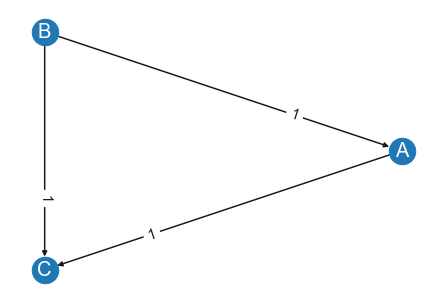

Instant Runoff winner: A
Plurality winners: A, C
Stable Voting winners: A, B, C
Simple Stable Voting winner: B
Condorcet winner: B


In [42]:
A = 0
B = 1 
C = 2

cmap = {A: "A", B: "B", C: "C" }
prof = Profile([
    (A, B, C),
    (B, A, C), 
    (C, B, A)
], 3, [2, 1, 2], cmap=cmap)

prof.display()

prof.display_margin_graph()
display_winners(prof, instant_runoff)
display_winners(prof, plurality)
display_winners(prof, stable_voting)
display_winners(prof, simple_stable_voting)
display_winners(prof, condorcet)


## Example 2

The following is an example without a Condorcet winner where the Instant Runoff winner ($D$) and the Plurality winners ($C$ and $D$),  and the Beat Path and Ranked Pairs winners ($B$, $C$ and $D$) are all different than the SV winner ($B$). 

+---+---+---+---+
| 2 | 1 | 1 | 1 |
+---+---+---+---+
| C | D | D | B |
| B | A | B | D |
| A | C | A | A |
| D | B | C | C |
+---+---+---+---+


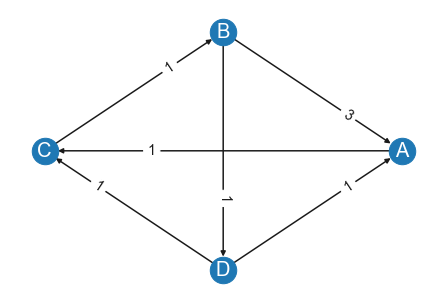

Instant Runoff winner: D
Plurality winners: C, D
Stable Voting winner: B
Simple Stable Voting winner: B
Beat Path winners: B, C, D
Ranked Pairs winners: B, C, D


In [43]:
A = 0
B = 1 
C = 2
D = 3

cmap = {A: "A", B: "B", C: "C", D: "D" }
prof = Profile([
    (C, B, A, D),
    (D, A, C, B), 
    (D, B, A, C),
    (B, D, A, C)
], 4, [2, 1, 1, 1], cmap=cmap)


prof.display()

prof.display_margin_graph()
display_winners(prof, instant_runoff)
display_winners(prof, plurality)
display_winners(prof, stable_voting)
display_winners(prof, simple_stable_voting)
display_winners(prof, beat_path_faster)
display_winners(prof, ranked_pairs)


## Example 3

A different profile generating the same margin graph as in Example 2 above. This is an example without a Condorcet winner where the Instant Runoff winner ($C$), the Plurality winners ($B$ and $C$), and the Beat Path and Ranked Pairs winners ($B$, $C$ and $D$) are all different than the SV winner ($B$).

+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| A | B | C | C | B |
| D | D | B | D | A |
| C | A | D | B | D |
| B | C | A | A | C |
+---+---+---+---+---+


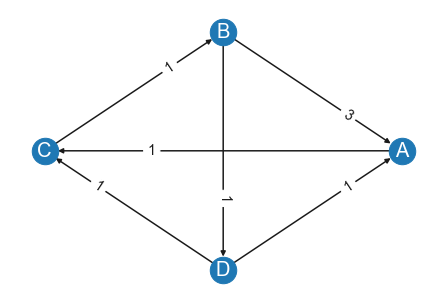

Instant Runoff winner: C
Plurality winners: B, C
Stable Voting winner: B
Simple Stable Voting winner: B
Beat Path winners: B, C, D
Ranked Pairs winners: B, C, D


In [44]:
A = 0
B = 1 
C = 2
D = 3

cmap = {A: "A", B: "B", C: "C", D: "D" }
prof = Profile([
    (A, D, C, B),
    (B, D, A, C),
    (C, B, D, A),
    (C, D, B, A), 
    (B, A, D, C)
], 4, [1, 1, 1, 1, 1], cmap=cmap)

prof.display()

prof.display_margin_graph()
display_winners(prof, instant_runoff)
display_winners(prof, plurality)
display_winners(prof, stable_voting)
display_winners(prof, simple_stable_voting)
display_winners(prof, beat_path_faster)
display_winners(prof, ranked_pairs)


## Example 4

An example in which the Ranked Pairs winners ($D$) is different than the Beat Path winners ($A$ and $D$), and both differ from the Stable Voting winner ($A$).

+---+---+---+---+---+---+---+---+
| 2 | 1 | 1 | 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+---+
| D | A | B | A | D | A | C | C |
| A | C | D | B | A | D | B | A |
| C | B | A | D | B | C | D | B |
| B | D | C | C | C | B | A | D |
+---+---+---+---+---+---+---+---+


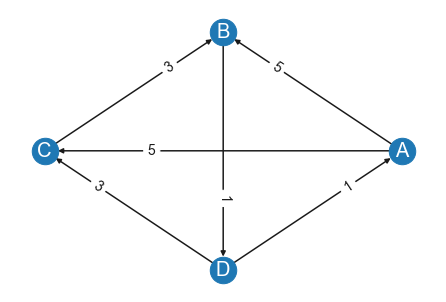

Instant Runoff winner: D
Plurality winners: A, D
Beat Path winners: A, D
Ranked Pairs winner: D
Stable Voting winner: A
Simple Stable Voting winner: A


In [45]:
A = 0
B = 1 
C = 2
D = 3

cmap = {A: "A", B: "B", C: "C", D: "D" }
prof = Profile([
    (D, A, C, B),
    (A, C, B, D), 
    (B, D, A, C),
    (A, B, D, C), 
    (D, A, B, C), 
    (A, D, C, B), 
    (C, B, D, A), 
    (C, A, B, D)
], 4, [2, 1, 1, 1, 1, 1, 1, 1], cmap=cmap)

prof.display()

prof.display_margin_graph()
display_winners(prof, instant_runoff)
display_winners(prof, plurality)
display_winners(prof, beat_path_faster)
display_winners(prof, ranked_pairs)
display_winners(prof, stable_voting)
display_winners(prof, simple_stable_voting)


In [46]:
# This code is available in voting/voting_methods.py but is included here for reference. 

def simple_stable_voting_mg_(mg, curr_cands = None, mem_sv_winners = {}): 
    '''
    Determine the Simple Stable Voting winners for the margin graph mg while keeping track 
    of the winners in any subprofiles checked during computation. 
    '''
    
    # curr_cands is the set of candidates who have not been removed
    curr_cands = curr_cands if not curr_cands is None else mg.nodes 
    sv_winners = list()

    matches = [(a, b) for a in curr_cands for b in curr_cands if a != b]
    margins = list(set([get_margin(mg, a, b) for a,b in matches]))
    
    if len(curr_cands) == 1: 
        mem_sv_winners[tuple(curr_cands)] = curr_cands
        return curr_cands, mem_sv_winners
    for m in sorted(margins, reverse=True):
        for a, b in [ab_match for ab_match in matches 
                     if get_margin(mg, ab_match[0], ab_match[1]) == m]:
            if a not in sv_winners: 
                cands_minus_b = sorted([c for c in curr_cands if c!= b])
                if tuple(cands_minus_b) not in mem_sv_winners.keys(): 
                    ws, mem_sv_winners = simple_stable_voting_mg_(mg, 
                                                                  curr_cands = [c for c in curr_cands if c != b],
                                                                  mem_sv_winners = mem_sv_winners )
                    mem_sv_winners[tuple(cands_minus_b)] = ws
                else: 
                    ws = mem_sv_winners[tuple(cands_minus_b)]
                if a in ws:
                    sv_winners.append(a)
        if len(sv_winners) > 0: 
            return sorted(sv_winners), mem_sv_winners
                
@vm_name("Simple Stable Voting")
def simple_stable_voting_mg(mg): 
    
    return simple_stable_voting_mg_(mg, curr_cands = None, mem_sv_winners = {})[0]

def find_undefeated_candidates_mg(mg, curr_cands = None):   
    """
    A path from candidate a to candidate b is a list of candidates starting with a and ending with b 
    such that each candidate in the list has a nonzero margin vs. the next candidate in the list. 
    The strength of a path is the minimum margin between consecutive candidates in the path 
    The strength of the pair of candidates (a,b) is strength of the strongest path from a to b.   
    We find these strengths using the Floyd-Warshall Algorithm.   
    
    A candidate c is undefeated if for all candidates d that is majority preferred to d, 
    the margin of c over d is greater than the strength of d to c. 
    
    Note that this is an implementation of the Split Cycle voting method. 
    """
    curr_cands = curr_cands if curr_cands is not None else mg.nodes
    margin_matrix = [[-np.inf for _ in curr_cands] for _ in curr_cands]
    
    for c1_idx,c1 in enumerate(curr_cands):
        for c2_idx,c2 in enumerate(curr_cands):
            if get_margin(mg, c1, c2) > 0 or c1 == c2:
                margin_matrix[c1_idx][c2_idx] = get_margin(mg, c1, c2)

    strength = list(map(lambda i : list(map(lambda j : j , i)) , margin_matrix))
    for i_idx, i in enumerate(curr_cands):         
        for j_idx, j in enumerate(curr_cands): 
            if i!= j:
                for k_idx, k in enumerate(curr_cands): 
                    if i!= k and j != k:
                        strength[j_idx][k_idx] = max(strength[j_idx][k_idx], min(strength[j_idx][i_idx],strength[i_idx][k_idx]))

    undefeated = {i:True for i in curr_cands}
    for i_idx, i in enumerate(curr_cands): 
        for j_idx,j in enumerate(curr_cands):
            if i!=j:
                if margin_matrix[j_idx][i_idx] > strength[i_idx][j_idx]: # the main difference with Beat Path
                    undefeated[i] = False
    return sorted([c for c in curr_cands if undefeated[c]])

def stable_voting_mg_(mg, curr_cands = None, mem_sv_winners = {}): 
    '''
    Determine the Simple Stable Voting winners for the margin graph mg while keeping track 
    of the winners in any subprofiles checked during computation. 
    '''
    
    # curr_cands is the set of candidates who have not been removed
    curr_cands = curr_cands if not curr_cands is None else mg.nodes 
    sv_winners = list()

    undefeated_candidates = find_undefeated_candidates_mg(mg, curr_cands = curr_cands)
    matches = [(a, b) for a in curr_cands for b in curr_cands if a != b if a in undefeated_candidates]
    margins = list(set([get_margin(mg, a, b) for a,b in matches]))
    
    if len(undefeated_candidates) == 1: 
        mem_sv_winners[tuple(curr_cands)] = curr_cands
        return curr_cands, mem_sv_winners
    for m in sorted(margins, reverse=True):
        for a, b in [ab_match for ab_match in matches 
                     if get_margin(mg, ab_match[0], ab_match[1]) == m]:
            if a not in sv_winners: 
                cands_minus_b = sorted([c for c in curr_cands if c!= b])
                if tuple(cands_minus_b) not in mem_sv_winners.keys(): 
                    ws, mem_sv_winners = stable_voting_mg_(mg, 
                                                           curr_cands = [c for c in curr_cands if c != b],
                                                           mem_sv_winners = mem_sv_winners )
                    mem_sv_winners[tuple(cands_minus_b)] = ws
                else: 
                    ws = mem_sv_winners[tuple(cands_minus_b)]
                if a in ws:
                    sv_winners.append(a)
        if len(sv_winners) > 0: 
            return sorted(sv_winners), mem_sv_winners
                
@vm_name("Stable Voting")
def stable_voting_mg(mg): 
    
    return stable_voting_mg_(mg, curr_cands = None, mem_sv_winners = {})[0]


## Example 3.4 and 3.5 from the paper

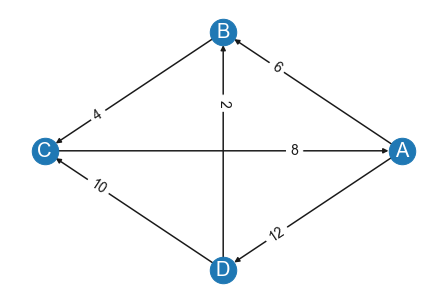

Stable Voting Winners: A, B, C, D
Simple Stable Voting Winners: A
Beat Path Winners: A
Ranked Pairs Winners: A



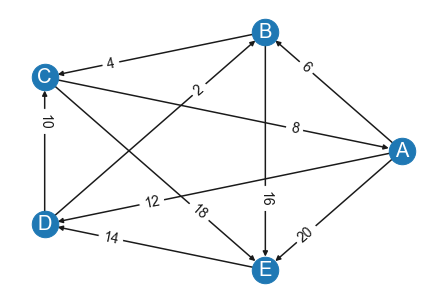

Stable Voting Winners: A
Simple Stable Voting Winners: A
Beat Path Winners: B
Ranked Pairs Winners: C


In [47]:


A = "A"
B = "B"
C = "C"
D = "D"
mg = nx.DiGraph()
mg.add_nodes_from([A, B, C, D])
mg.add_weighted_edges_from([
    (A, B, 6),
    (A, D, 12),
    (B, C, 4), 
    (C, A, 8), 
    (D, B, 2),
    (D, C, 10)
])

display_mg(mg)
print("Stable Voting Winners:",  ', '.join(stable_voting_mg(mg)))
print("Simple Stable Voting Winners:",  ', '.join(simple_stable_voting_mg(mg)))
print("Beat Path Winners:",  ', '.join(beat_path_mg(mg)))
print("Ranked Pairs Winners:",  ', '.join(ranked_pairs_mg(mg)))

print("")


A = "A"
B = "B"
C = "C"
D = "D"
E = "E"

mg = nx.DiGraph()
mg.add_nodes_from([A, B, C, D])
mg.add_weighted_edges_from([
    (A, B, 6),
    (A, D, 12),
    (B, C, 4), 
    (C, A, 8), 
    (D, B, 2),
    (D, C, 10),
    (A, E, 20), 
    (B, E, 16), 
    (C, E, 18), 
    (E, D, 14)
])

display_mg(mg)
print("Stable Voting Winners:",  ', '.join(stable_voting_mg(mg)))
print("Simple Stable Voting Winners:",  ', '.join(simple_stable_voting_mg(mg)))
print("Beat Path Winners:",  ', '.join(beat_path_mg(mg)))
print("Ranked Pairs Winners:",  ', '.join(ranked_pairs_mg(mg)))

